# Research Paper Classification for COVID-19 Research

There has been great momentum from the machine learning community to extract insights from the increasingly growing COVID-19 Datasets, such as the Allen Institute for AI [Open Research Dataset](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) as well as the data repository by [Johns Hopkins CSSE](https://github.com/CSSEGISandData/COVID-19).

We believe the most powerful insights can be brought through cross-functional collaboration, such as between infectious disease experts and machine learning practitioners. 

More importantly, once powerful predictive and explanatory models are built, it is especially important to be able to deploy and enable access to these models at scale to power solutions that can solve real-life challenges.

In this small tutorial we will show how you can deploy your machine learning solutions at scale, and we will use a practical example. For this we will be building a simple text classifier using the Allen Institute for AI COVID-19 Open Research Dataset which has been open sourced with over 44,000 scholarly articles on COVID-19, together with the [Arxiv Metadata Research Dataset](https://www.kaggle.com/tayorm/arxiv-papers-metadata) which contains over 1.5M papers.

In this tutorial we will focus primarily around the techniques to productionise an already trained model, and we will showcase how you're able to leverage the Seldon Core Prepackaged Model Servers, the Python Language Wrapper, and some of our AI Explainability infrastructure tools.

## Tutorial Overview

The steps that we will be following in this tutorial include

1) Train and build a simple NLP model with SKLearn and SpaCy

2) Explain your model predictions using Alibi Explain

3) Containerize your model using Seldon Core Language Wrappers and deploy to Kubernetes

5) Test your deployed model by sending requests

6) Deploy our standard Alibi TextExplainer 

7) Test your deployed explainer by sending requests

### Before you start
Make sure you install the following dependencies, as they are critical for this example to work:

* Seldon Core v1.1+ installed with Istio Ingress Enabled ([Documentation Instructions](https://docs.seldon.io/projects/seldon-core/en/latest/workflow/install.html#ingress-support))
* A Kubernetes Cluster with all dependencies specified in the Seldon Core page

Let's get started! 🚀🔥

## 0) Prepare your development environment

First we want to install all the dependencies. 

These are all going to be in our `requirements-dev.txt` file.

In [1]:
%%writefile requirements-dev.txt
scipy>= 0.13.3
scikit-learn>=0.18
spacy==2.0.18
dill==0.2.9
xai==0.0.5
alibi==0.4.0

Overwriting requirements-dev.txt


We can then use pip to install the requirements above:

In [2]:
# Let's first install any dependencies
!pip install -r requirements-dev.txt

      Successfully uninstalled matplotlib-3.1.3
  Found existing installation: wrapt 1.12.1
    Uninstalling wrapt-1.12.1:
      Successfully uninstalled wrapt-1.12.1


Now that everything is installed, we can import all our dependencies.

In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from seldon_core.seldon_client import SeldonClient
import dill
import sys, os
import xai

pd.set_option("display.notebook_repr_html", True)

### Let's download the SpaCy English Model

In [2]:
from spacy.cli import download

download("en_core_web_sm")


    Linking successful
    /home/alejandro/miniconda3/lib/python3.7/site-packages/en_core_web_sm
    -->
    /home/alejandro/miniconda3/lib/python3.7/site-packages/spacy/data/en_core_web_sm

    You can now load the model via spacy.load('en_core_web_sm')



## 1) Train and build your NLP model with SKLearn and SpaCy

We can now get started with the training of our model. 

For this tutorial we are going to focus primarily on the productionisation of the model, so we will use a significantly smaller dataset.

More specifically we selected randomly 2000 abstracts from the COVID-19 Open Research Dataset, and 2000 abstracts from the [Arxiv Papers Metadata Dataset](https://www.kaggle.com/tayorm/arxiv-papers-metadata) to compare against to provide a (very simplified) example of an NLP classification model.

In [45]:
df = pd.read_csv("https://raw.githubusercontent.com/axsaucedo/datasets/master/data/research_paper_abstracts.csv")

This dataset contains 4000 abstracts randomly picked from the datasets mentioned in the introduction, 2000 COVID-19 related and 2000 nonCOVID19 related

In [46]:
df.tail()

,abstract,is_covid
3995,This article summarizes current knowledge abou...,1
3996,While epidemiological models have traditionall...,1
3997,TGEV and PEDV are porcine coronaviruses with t...,1
3998,"Metagenomics, i.e., the sequencing and analysi...",1
3999,Population genetic diversity plays a prominent...,1


We can see that we have a distributed set of examples to train and test our model

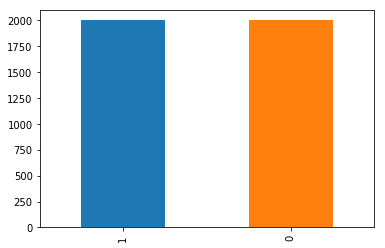

In [5]:
# Let's see how many examples we have of each class
df["is_covid"].value_counts().plot.bar()

### Split our train test dataset

We first start by splitting our train and test dataset, making sure we have an even breakdown of examples for train test

In [6]:
x = df["abstract"].values
y = df["is_covid"].values
x_train, x_test, y_train, y_test = train_test_split(
    x, y, 
    stratify=y, 
    random_state=42, 
    test_size=0.1, shuffle=True)

### Train our model: Clean Text
As the first step for our model we'll first clean the incoming text data for any less meaningful characters and symbols

For this, we have created a CleanTextTransformer class that will be doing the text pre-processing

In [7]:
from ml_utils import CleanTextTransformer


    Linking successful
    /home/alejandro/miniconda3/lib/python3.7/site-packages/en_core_web_sm
    -->
    /home/alejandro/miniconda3/lib/python3.7/site-packages/spacy/data/en_core_web_sm

    You can now load the model via spacy.load('en_core_web_sm')



In [8]:
# Clean the text
clean_text_transformer = CleanTextTransformer()
x_train_clean = clean_text_transformer.transform(x_train)

### Train our model: Tokenize
We now convert our input text into tokens - for this we use the SpaCy module.

In [9]:
from ml_utils import SpacyTokenTransformer

In [10]:
# Tokenize the text and get the lemmas
spacy_tokenizer = SpacyTokenTransformer()
x_train_tokenized = spacy_tokenizer.transform(x_train_clean)

### Train our model: Vectorize

Now we have to convert our tokens into input our model can read, so we convert our tokens into vector using our TFIDF vectorizer.

In [11]:
# Build tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    preprocessor=lambda x: x, 
    tokenizer=lambda x: x, 
    token_pattern=None,
    ngram_range=(1, 3))

tfidf_vectorizer.fit(x_train_tokenized)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 3), norm='l2',
        preprocessor=<function <lambda> at 0x7f9c0ddce5f0>,
        smooth_idf=True, stop_words=None, strip_accents=None,
        sublinear_tf=False, token_pattern=None,
        tokenizer=<function <lambda> at 0x7f9c0ddce7a0>, use_idf=True,
        vocabulary=None)

Transform our tokens to tfidf vectors

In [13]:
x_train_tfidf = tfidf_vectorizer.transform(
    x_train_tokenized)

### Train your model: Prediction

Finally we want to be able to predict using our model. For this, we'll use a logistic regression classifier:

In [14]:
# Train logistic regression classifier
lr = LogisticRegression(C=0.1, solver='sag')
lr.fit(x_train_tfidf, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

### Evaluate your model

Now that we've trained our model we can test its performance against our test dataset. 

Let's run a single instance through our classifier first.

In [19]:
def predict_fn(x):
    x_c = clean_text_transformer.transform(x)
    x_s = spacy_tokenizer.transform(x_c)
    x_t = tfidf_vectorizer.transform(x_s)
    return lr.predict(x_t)

print(x_test[0:1])
print(f"Expected class: {y_test[0:1]}")
print(f"Predicted class: {predict_fn(x_test[0:1])}")

['We report theoretical and simulation studies of phase coexistence in model globular protein solutions, based on short-range, central, pair potential representations of the interaction among macro-particles. After reviewing our previous investigations of hard-core Yukawa and generalised Lennard-Jones potentials, we report more recent results obtained within a DLVO-like description of lysozyme solutions in water and added salt. We show that a one-parameter fit of this model based on Static Light Scattering and Self-Interaction Chromatography data in the dilute protein regime, yields demixing and crystallization curves in good agreement with experimental protein-rich/protein-poor and solubility envelopes. The dependence of cloud and solubility points temperature of the model on the ionic strength is also investigated. Our findings highlight the minimal assumptions on the properties of the microscopic interaction sufficient for a satisfactory reproduction of the phase diagram topology of

Now to evaluate our model we run all our test dataset and extract predictions, so we can evaluate them.

In [20]:
pred = predict_fn(x_test)

And now we can see the performance of the predictions, which looks good specifically in this toy dataset.

,target
precision,0.994898
recall,0.975000
specificity,0.995000
accuracy,0.985000
auc,0.985000
f1,0.984848


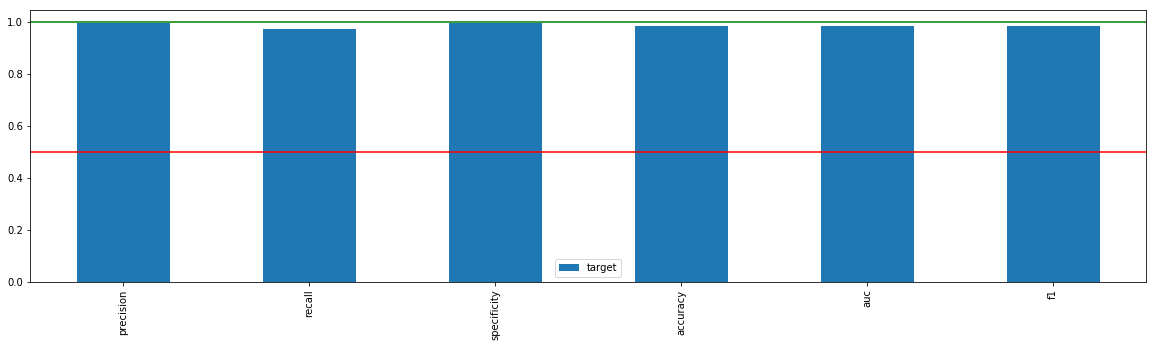

In [22]:
xai.metrics_plot(y_test, pred)

## 2) Explain your model predictions using Alibi Explain

We will now use the Alibi library to explain predictions from the model we've built

We start by using our alibi explainer for text, and the Spacy NLP module

In [25]:
import spacy
import alibi

nlp = spacy.load("en_core_web_sm", parser=False, entity=False)

In order to create a text explainer, we just have to pass the `predict_fn` that we defined above, as it will reverse engineer the explanations

In [29]:
explainer = alibi.explainers.AnchorText(nlp, predict_fn)

Now we select a prediction which we will want to explain, in this case we select the index `1` from our test dataset

In [30]:
x_explain = x_test[1]
x_explain

'The modifiable areal unit problem, MAUP, is ever-present although not always appreciated. Through real examples, this article outlines the basic causes of MAUP, namely changes in the size, shape, and/or orientation of spatial categories/polygons used to map areal data. The visual effects of changes to mapped data are obvious even though the impacts on our understanding of the world are profound. The article concludes with a discussion of technical and broader strategic approaches for confronting the effects of MAUP on our treatment and interpretation of areal data.'

And we simply send the prediction request into our explainer, which should take about 10-30 seconds.

In [31]:
explanation = explainer.explain(x_explain, threshold=0.95, use_unk=True)

Finally we can print our explanations, which in this case it will tell us the tokens that had the strongest predictive power

In [32]:
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print(f"\nOriginal Sample:\n{x_explain}")
print('\nFirst Example where anchor applies and model predicts is_covid==True')
print(f"\n{explanation.raw['examples'][-1]['covered_true'][0]}".replace("UNK", "___"))
print('\n\nExample where anchor applies and model predicts is_covid==False')
print(f"\n{explanation.raw['examples'][-1]['covered_false'][0]}".replace("UNK", "___"))

Anchor: real
Precision: 0.97

Original Sample:
The modifiable areal unit problem, MAUP, is ever-present although not always appreciated. Through real examples, this article outlines the basic causes of MAUP, namely changes in the size, shape, and/or orientation of spatial categories/polygons used to map areal data. The visual effects of changes to mapped data are obvious even though the impacts on our understanding of the world are profound. The article concludes with a discussion of technical and broader strategic approaches for confronting the effects of MAUP on our treatment and interpretation of areal data.

First Example where anchor applies and model predicts is_covid==True

___ modifiable areal unit ___ , ___ ___ ___ ever - present ___ ___ always ___ . Through real ___ ___ this ___ ___ ___ ___ ___ ___ ___ , namely ___ in the ___ ___ ___ ___ ___ ___ of spatial ___ / ___ used ___ ___ areal data ___ The ___ ___ ___ ___ ___ mapped data are obvious even ___ the impacts ___ our unders

## 2) Build your containerized model

Now that we have trained our model, and we know how to use the Alibi explainability library, we can actually deploy these models.

### First use Seldon Core to containerise the model

To get started we will use Seldon to Containerise the model, for this we will export the models we trained above into the current folder

In [33]:
# These are the models we'll deploy
with open('tfidf_vectorizer.model', 'wb') as model_file:
    dill.dump(tfidf_vectorizer, model_file)
with open('lr.model', 'wb') as model_file:
    dill.dump(lr, model_file)

The way Seldon Core works from there, is that we need to build a Python Wrapper that exposes the functionality through the `predict` method.

We define a file below called `ResearchClassifier.py` which loads the models we exported and then uses them for any predictions.

Seldon Core will then convert this file into a fully fledged microservice.

In [34]:
%%writefile ResearchClassifier.py

import dill

from ml_utils import CleanTextTransformer, SpacyTokenTransformer

class ResearchClassifier(object):
    def __init__(self):
        
        self._clean_text_transformer = CleanTextTransformer()
        self._spacy_tokenizer = SpacyTokenTransformer()
        
        with open('tfidf_vectorizer.model', 'rb') as model_file:
            self._tfidf_vectorizer = dill.load(model_file)
           
        with open('lr.model', 'rb') as model_file:
            self._lr_model = dill.load(model_file)

    def predict(self, X, feature_names):
        clean_text = self._clean_text_transformer.transform(X)
        spacy_tokens = self._spacy_tokenizer.transform(clean_text)
        tfidf_features = self._tfidf_vectorizer.transform(spacy_tokens)
        predictions = self._lr_model.predict_proba(tfidf_features)
        return predictions



Overwriting ResearchClassifier.py


Before we containerise this Python wrapper, we can test it to make sure it predicts as expected:

In [36]:
from ResearchClassifier import ResearchClassifier

sample = x_test[1:2]

print(f"Input data: {sample}")
print(f"Predicted probabilities for each class: {ResearchClassifier().predict(sample, ['feature_name'])}")
print(f"Actual class: {y_test[1:2]}")

Input data: ['The modifiable areal unit problem, MAUP, is ever-present although not always appreciated. Through real examples, this article outlines the basic causes of MAUP, namely changes in the size, shape, and/or orientation of spatial categories/polygons used to map areal data. The visual effects of changes to mapped data are obvious even though the impacts on our understanding of the world are profound. The article concludes with a discussion of technical and broader strategic approaches for confronting the effects of MAUP on our treatment and interpretation of areal data.']
Predicted probabilities for each class: [[0.55033599 0.44966401]]
Actual class: [1]


### Create Docker Image with the S2i utility

Now using the S2I command line interface we wrap our current model to seve it through the Seldon interface

We will need to first define the dependencies that we use in our wrapper into a `requirements.txt` file below:

In [42]:
%%writefile requirements.txt
scipy>= 0.13.3
scikit-learn>=0.18
spacy==2.0.18
dill==0.2.9

Overwriting requirements.txt


We then have to define the environment variables required by Seldon, such as the name of your model file

In [43]:
%%writefile .s2i/environment

MODEL_NAME=ResearchClassifier
API_TYPE=REST
SERVICE_TYPE=MODEL
PERSISTENCE=0

Overwriting .s2i/environment


And now that everything is configured, we can build the `research-classifier:0.1` image using the Seldon Command below - it will take some time depending on internet as it will need to download the docker image, and all the relevant dependencies.

In [44]:
!s2i build . seldonio/seldon-core-s2i-python3:0.18 research-classifier:0.1

tar: scripts: time stamp 2020-03-27 15:37:42.2163223 is 32685.794467881 s in the future
tar: src/.gitignore: time stamp 2020-03-27 15:37:42.2173814 is 32685.791911573 s in the future
tar: src/.ipynb_checkpoints/README-checkpoint.ipynb: time stamp 2020-03-27 15:37:42.2195402 is 32685.793796073 s in the future
tar: src/.ipynb_checkpoints: time stamp 2020-03-27 15:37:42.219017 is 32685.79316194 s in the future
tar: src/.s2i/environment: time stamp 2020-03-27 15:37:42.2206062 is 32685.794620056 s in the future
tar: src/.s2i: time stamp 2020-03-27 15:37:42.2206062 is 32685.794555815 s in the future
tar: src/MyModel.py: time stamp 2020-03-27 15:37:42.2216653 is 32685.795477548 s in the future
tar: src/README.ipynb: time stamp 2020-03-27 15:37:42.2227778 is 32685.796025306 s in the future
tar: src/README.md: time stamp 2020-03-27 15:37:42.2238999 is 32685.79699704 s in the future
tar: src/README_files/README_12_1.png: time stamp 2020-03-27 15:37:42.2244528 is 32685.797339773 s in the future
t

tar: src/data/arxiv-papers-metadata/per_category/cond-mat.dis-nn.tsv.xz: time stamp 2020-03-27 15:37:52.0766927 is 32656.258833123 s in the future
tar: src/data/arxiv-papers-metadata/per_category/cond-mat.mes-hall.tsv: time stamp 2020-03-27 15:37:52.227245 is 32655.720420632 s in the future
tar: src/data/arxiv-papers-metadata/per_category/cond-mat.mes-hall.tsv.xz: time stamp 2020-03-27 15:37:52.2578995 is 32655.585732682 s in the future
tar: src/data/arxiv-papers-metadata/per_category/cond-mat.mtrl-sci.tsv: time stamp 2020-03-27 15:37:52.4050173 is 32655.047878965 s in the future
tar: src/data/arxiv-papers-metadata/per_category/cond-mat.mtrl-sci.tsv.xz: time stamp 2020-03-27 15:37:52.4400009 is 32654.94859304 s in the future
tar: src/data/arxiv-papers-metadata/per_category/cond-mat.other.tsv: time stamp 2020-03-27 15:37:52.4709996 is 32654.85067724 s in the future
tar: src/data/arxiv-papers-metadata/per_category/cond-mat.other.tsv.xz: time stamp 2020-03-27 15:37:52.4780325 is 32654.828

tar: src/data/arxiv-papers-metadata/per_category/cs.IR.tsv.xz: time stamp 2020-03-27 15:37:54.7110814 is 32648.458951229 s in the future
tar: src/data/arxiv-papers-metadata/per_category/cs.IT.tsv: time stamp 2020-03-27 15:37:54.7814604 is 32648.196587538 s in the future
tar: src/data/arxiv-papers-metadata/per_category/cs.IT.tsv.xz: time stamp 2020-03-27 15:37:54.7973705 is 32648.138303279 s in the future
tar: src/data/arxiv-papers-metadata/per_category/cs.LG.tsv: time stamp 2020-03-27 15:37:54.8971936 is 32647.787132546 s in the future
tar: src/data/arxiv-papers-metadata/per_category/cs.LG.tsv.xz: time stamp 2020-03-27 15:37:54.9202942 is 32647.705963072 s in the future
tar: src/data/arxiv-papers-metadata/per_category/cs.LO.tsv: time stamp 2020-03-27 15:37:54.9421584 is 32647.632262647 s in the future
tar: src/data/arxiv-papers-metadata/per_category/cs.LO.tsv.xz: time stamp 2020-03-27 15:37:54.9481914 is 32647.61765988 s in the future
tar: src/data/arxiv-papers-metadata/per_category/cs

tar: src/data/arxiv-papers-metadata/per_category/hep-lat.tsv: time stamp 2020-03-27 15:37:55.658046 is 32645.239220833 s in the future
tar: src/data/arxiv-papers-metadata/per_category/hep-lat.tsv.xz: time stamp 2020-03-27 15:37:55.669058 is 32645.206699083 s in the future
tar: src/data/arxiv-papers-metadata/per_category/hep-ph.tsv: time stamp 2020-03-27 15:37:55.9484086 is 32644.007546793 s in the future
tar: src/data/arxiv-papers-metadata/per_category/hep-ph.tsv.xz: time stamp 2020-03-27 15:37:56.0049724 is 32643.653673402 s in the future
tar: src/data/arxiv-papers-metadata/per_category/hep-th.tsv: time stamp 2020-03-27 15:37:56.5614699 is 32642.858661654 s in the future
tar: src/data/arxiv-papers-metadata/per_category/hep-th.tsv.xz: time stamp 2020-03-27 15:37:56.6106951 is 32642.670259421 s in the future
tar: src/data/arxiv-papers-metadata/per_category/math-ph.tsv: time stamp 2020-03-27 15:37:56.7314613 is 32642.258876579 s in the future
tar: src/data/arxiv-papers-metadata/per_categ

tar: src/data/arxiv-papers-metadata/per_category/math.QA.tsv: time stamp 2020-03-27 15:37:57.9800192 is 32638.033771055 s in the future
tar: src/data/arxiv-papers-metadata/per_category/math.QA.tsv.xz: time stamp 2020-03-27 15:37:57.986824 is 32638.017003171 s in the future
tar: src/data/arxiv-papers-metadata/per_category/math.RA.tsv: time stamp 2020-03-27 15:37:58.0061614 is 32637.952000038 s in the future
tar: src/data/arxiv-papers-metadata/per_category/math.RA.tsv.xz: time stamp 2020-03-27 15:37:58.0125169 is 32637.940450855 s in the future
tar: src/data/arxiv-papers-metadata/per_category/math.RT.tsv: time stamp 2020-03-27 15:37:58.0512271 is 32637.844617772 s in the future
tar: src/data/arxiv-papers-metadata/per_category/math.RT.tsv.xz: time stamp 2020-03-27 15:37:58.0603842 is 32637.82793748 s in the future
tar: src/data/arxiv-papers-metadata/per_category/math.SG.tsv: time stamp 2020-03-27 15:37:58.0729001 is 32637.790198955 s in the future
tar: src/data/arxiv-papers-metadata/per_c

tar: src/data/arxiv-papers-metadata/per_category/physics.hist-ph.tsv.xz: time stamp 2020-03-27 15:37:58.9488313 is 32635.375371261 s in the future
tar: src/data/arxiv-papers-metadata/per_category/physics.ins-det.tsv: time stamp 2020-03-27 15:37:59.0437617 is 32635.30757427 s in the future
tar: src/data/arxiv-papers-metadata/per_category/physics.ins-det.tsv.xz: time stamp 2020-03-27 15:37:59.0659506 is 32635.291619978 s in the future
tar: src/data/arxiv-papers-metadata/per_category/physics.med-ph.tsv: time stamp 2020-03-27 15:37:59.0895164 is 32635.270927495 s in the future
tar: src/data/arxiv-papers-metadata/per_category/physics.med-ph.tsv.xz: time stamp 2020-03-27 15:37:59.0979669 is 32635.268291162 s in the future
tar: src/data/arxiv-papers-metadata/per_category/physics.optics.tsv: time stamp 2020-03-27 15:37:59.2184476 is 32635.088327346 s in the future
tar: src/data/arxiv-papers-metadata/per_category/physics.optics.tsv.xz: time stamp 2020-03-27 15:37:59.2344409 is 32635.044541554 s

tar: src/data/arxiv-papers-metadata/per_category/quant-ph.tsv: time stamp 2020-03-27 15:37:59.8628438 is 32632.937447627 s in the future
tar: src/data/arxiv-papers-metadata/per_category/quant-ph.tsv.xz: time stamp 2020-03-27 15:37:59.9078411 is 32632.784999844 s in the future
tar: src/data/arxiv-papers-metadata/per_category/solv-int.tsv: time stamp 2020-03-27 15:37:59.9117014 is 32632.778104052 s in the future
tar: src/data/arxiv-papers-metadata/per_category/solv-int.tsv.xz: time stamp 2020-03-27 15:37:59.9139876 is 32632.778020677 s in the future
tar: src/data/arxiv-papers-metadata/per_category/stat.AP.tsv: time stamp 2020-03-27 15:37:59.9368793 is 32632.691195844 s in the future
tar: src/data/arxiv-papers-metadata/per_category/stat.AP.tsv.xz: time stamp 2020-03-27 15:37:59.9449725 is 32632.667367436 s in the future
tar: src/data/arxiv-papers-metadata/per_category/stat.CO.tsv: time stamp 2020-03-27 15:37:59.956093 is 32632.62259942 s in the future
tar: src/data/arxiv-papers-metadata/p

## 3) Test your model as a docker container

In [38]:
# Remove previously deployed containers for this model
!docker rm -f research_predictor

Error: No such container: reddit_predictor


In [39]:
!docker run --name "research_predictor" -d --rm -p 5001:5000 research-classifier:0.1

be29c6a00adec0f708dc5a1c83613e0656fddc06daba4ca02d93b5a7ece9b92b


### Make sure you wait for language model
SpaCy will download the English language model, so you have to make sure the container finishes downloading it before it can be used. You can view this by running the logs until you see "Linking successful".

In [ ]:
# Here we need to wait until we see "Linking successful", as it's downloading the Spacy English model
# You can hit stop when this happens
!docker logs -t -f research_predictor

In [43]:
# We now test the REST endpoint expecting the same result
endpoint = "0.0.0.0:5001"
batch = sample
payload_type = "ndarray"

sc = SeldonClient(microservice_endpoint=endpoint)
response = sc.microservice(
    data=batch,
    method="predict",
    payload_type=payload_type,
    names=["tfidf"])

print(response)

Success:True message:
Request:
data {
  names: "tfidf"
  ndarray {
    values {
      string_value: "This is the study that the article is based on:\r\n\r\nhttps://www.nature.com/articles/nature25778.epdf"
    }
  }
}

Response:
meta {
}
data {
  names: "t:0"
  names: "t:1"
  ndarray {
    values {
      list_value {
        values {
          number_value: 0.8276709475641506
        }
        values {
          number_value: 0.1723290524358494
        }
      }
    }
  }
}



In [44]:
# We now stop it to run it in docker
!docker stop research_predictor

reddit_predictor


## 4) Run Seldon in your kubernetes cluster


## Setup Seldon Core

Use the setup notebook to [Setup Cluster](../../seldon_core_setup.ipynb#Setup-Cluster) with [Ambassador Ingress](../../seldon_core_setup.ipynb#Ambassador) and [Install Seldon Core](../../seldon_core_setup.ipynb#Install-Seldon-Core). Instructions [also online](./seldon_core_setup.html).

## 5) Deploy your model with Seldon
We can now deploy our model by using the Seldon graph definition:

In [117]:
%%writefile research-deployment.yaml
---
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: research-deployment
spec:
  name: research-spec
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - image: research-classifier:0.1
          imagePullPolicy: IfNotPresent
          name: research-model
    graph:
      children: []
      name: research-model
      endpoint:
        type: REST
      type: MODEL
    name: research-pred
    replicas: 1


Writing research-deployment.yaml


In [61]:
!kubectl apply -f research-deployment.yaml

seldondeployment.machinelearning.seldon.io/reddit-classifier created


In [63]:
!kubectl get pods 

NAME                                                    READY   STATUS    RESTARTS   AGE
ambassador-7bfc87f865-jkxs8                             1/1     Running   0          5m2s
ambassador-7bfc87f865-nr7bn                             1/1     Running   0          5m2s
ambassador-7bfc87f865-q4lng                             1/1     Running   0          5m2s
reddit-classifier-single-model-9199e4b-bcc5cdcc-g8j2q   2/2     Running   1          77s
seldon-operator-controller-manager-0                    1/1     Running   1          5m23s


## 6) Interact with your model through API
Now that our Seldon Deployment is live, we are able to interact with it through its API.

There are two options in which we can interact with our new model. These are:

a) Using CURL from the CLI (or another rest client like Postman)

b) Using the Python SeldonClient

#### a) Using CURL from the CLI

In [66]:
%%bash
curl -X POST -H 'Content-Type: application/json' \
    -d "{'data': {'names': ['text'], 'ndarray': ['Hello world this is a test']}}" \
    http://127.0.0.1/seldon/default/research-deployment/api/v0.1/predictions

{
  "meta": {
    "puid": "bvj1rjiq3vvnieo0oir4h7bf6f",
    "tags": {
    },
    "routing": {
    },
    "requestPath": {
      "classifier": "reddit-classifier:0.1"
    },
    "metrics": []
  },
  "data": {
    "names": ["t:0", "t:1"],
    "ndarray": [[0.6815614604065544, 0.3184385395934456]]
  }
}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   372  100   300  100    72   1522    365 --:--:-- --:--:-- --:--:--  1897


#### b) Using the Python SeldonClient

In [70]:
from seldon_core.seldon_client import SeldonClient
import numpy as np

host = "localhost"
port = "80" # Make sure you use the port above
batch = np.array(["Hello world this is a test"])
payload_type = "ndarray"
deployment_name="reddit-deployment"
transport="rest"
namespace="default"

sc = SeldonClient(
    gateway="ambassador", 
    ambassador_endpoint=host + ":" + port,
    namespace=namespace)

client_prediction = sc.predict(
    data=batch, 
    deployment_name=deployment_name,
    names=["text"],
    payload_type=payload_type,
    transport="rest")

print(client_prediction)

Success:True message:
Request:
data {
  names: "text"
  ndarray {
    values {
      string_value: "Hello world this is a test"
    }
  }
}

Response:
meta {
  puid: "uld2famhfrb97vd7regu0q7k32"
  requestPath {
    key: "classifier"
    value: "reddit-classifier:0.1"
  }
}
data {
  names: "t:0"
  names: "t:1"
  ndarray {
    values {
      list_value {
        values {
          number_value: 0.6815614604065544
        }
        values {
          number_value: 0.3184385395934456
        }
      }
    }
  }
}

